In [1]:
#pip install shapely

In [2]:
#Import dependencies
import pandas as pd
import numpy as np
import json
from shapely.geometry import shape, Point
import path
import glob
from numpy import radians, cos, sin, arcsin, sqrt
import datetime 
import matplotlib.pyplot as plt


In [3]:
#Import CSV

locations_df = pd.read_csv('./Capital_Bike_Share_Locations.csv')
locations_df["NUMBER_OF_BIKES"] = locations_df["NUMBER_OF_BIKES"] + locations_df["NUMBER_OF_EMPTY_DOCKS"]
locations_df.drop(columns=["NUMBER_OF_EMPTY_DOCKS", "INSTALLED", "LOCKED", "INSTALL_DATE", "REMOVAL_DATE", "TEMPORARY_INSTALL", "SE_ANNO_CAD_DATA", "X", "Y"], inplace=True)
locations_df.rename(columns={'NUMBER_OF_BIKES': 'TOTAL_BIKE_DOCKS'}, inplace=True)
locations_df["WARD"] = ""
locations_df.head()

,OBJECTID,ID,ADDRESS,TERMINAL_NUMBER,LATITUDE,LONGITUDE,TOTAL_BIKE_DOCKS,OWNER,WARD
0,237709931,90,34th St & Wisconsin Ave NW,31226,38.916442,-77.068200,8,DC,
1,237709932,91,13th St & New York Ave NW,31227,38.900283,-77.029822,21,DC,
2,237709933,92,8th & H St NW,31228,38.899700,-77.023086,30,DC,
3,237709934,93,10th & Monroe St NE,31504,38.932514,-76.992889,11,DC,
4,237709935,94,Eckington Pl & Q St NE,31505,38.910972,-77.004950,22,DC,


In [4]:
# load GeoJSON file containing sectors
with open('./dc-ward-map-overlay.geojson') as f:
    js = json.load(f)

# construct point based on lon/lat returned by geocoder
# check each polygon to see if it contains the point
for index, row in locations_df.iterrows():
    point = Point(row['LONGITUDE'],row['LATITUDE'])
    for feature in js['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            locations_df.loc[index,'WARD'] = feature["properties"]["name"]

locations_df["WARD"] = locations_df["WARD"].str.replace("Ward ", "") 



In [5]:
locations_df.head()

,OBJECTID,ID,ADDRESS,TERMINAL_NUMBER,LATITUDE,LONGITUDE,TOTAL_BIKE_DOCKS,OWNER,WARD
0,237709931,90,34th St & Wisconsin Ave NW,31226,38.916442,-77.068200,8,DC,2
1,237709932,91,13th St & New York Ave NW,31227,38.900283,-77.029822,21,DC,2
2,237709933,92,8th & H St NW,31228,38.899700,-77.023086,30,DC,2
3,237709934,93,10th & Monroe St NE,31504,38.932514,-76.992889,11,DC,5
4,237709935,94,Eckington Pl & Q St NE,31505,38.910972,-77.004950,22,DC,5


In [6]:
#Loop thru all CSV files, and add to DataFrame
list_ = []
path = '../capbikeshare stuff/CSV Files'
allFiles = glob.glob(path + "/*.csv")
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    list_.append(df)
frame = pd.concat(list_, axis = 0, ignore_index = True)

In [7]:
merged_df = pd.merge(frame, locations_df, left_on='Start station number', right_on='TERMINAL_NUMBER')
merged_df.rename(columns={'WARD': 'Start Ward'}, inplace=True)
merged_df.drop(columns=["OBJECTID", "ID", "ADDRESS", "TERMINAL_NUMBER", "LATITUDE", "LONGITUDE", "TOTAL_BIKE_DOCKS", "OWNER"], inplace=True)


In [8]:
bs_ward = pd.merge(merged_df, locations_df, left_on='End station number', right_on='TERMINAL_NUMBER')
bs_ward.rename(columns={'WARD': 'End Ward'}, inplace=True)
bs_ward = bs_ward[bs_ward["OWNER"] == "DC"]
bs_ward.drop(columns=["OBJECTID", "ID", "ADDRESS", "TERMINAL_NUMBER", "LATITUDE", "LONGITUDE", "TOTAL_BIKE_DOCKS", "OWNER"], inplace=True)


In [9]:
bs_ward.head()

,Duration,Start date,End date,Start station number,Start station,End station number,End station,Bike number,Member type,Start Ward,End Ward
0,679,2018-05-01 00:00:00,2018-05-01 00:11:19,31302,Wisconsin Ave & Newark St NW,31307,3000 Connecticut Ave NW / National Zoo,W22771,Member,3,3
1,320,2018-05-01 06:55:30,2018-05-01 07:00:51,31302,Wisconsin Ave & Newark St NW,31307,3000 Connecticut Ave NW / National Zoo,W21410,Member,3,3
2,314,2018-05-01 10:37:14,2018-05-01 10:42:29,31302,Wisconsin Ave & Newark St NW,31307,3000 Connecticut Ave NW / National Zoo,W20032,Member,3,3
3,687,2018-05-01 20:48:32,2018-05-01 21:00:00,31302,Wisconsin Ave & Newark St NW,31307,3000 Connecticut Ave NW / National Zoo,W21882,Member,3,3
4,557,2018-05-02 13:05:04,2018-05-02 13:14:22,31302,Wisconsin Ave & Newark St NW,31307,3000 Connecticut Ave NW / National Zoo,W20409,Member,3,3


In [10]:
bs_ward_count_gb = bs_ward.groupby("Start Ward")
bs_ward_count = bs_ward_count_gb["Start station number"].count()
bs_ward_count = pd.DataFrame(bs_ward_count).reset_index()
bs_ward_count = bs_ward_count.drop(bs_ward_count.index[0]).reset_index(drop=True)
bs_ward_count.rename(columns={'Start station number': 'Total Rides'}, inplace=True)
bs_ward_count

,Start Ward,Total Rides
0,1,382944
1,2,1647351
2,3,83923
3,4,39175
4,5,129719
5,6,750547
6,7,9066
7,8,10758


In [11]:
bs_ward_count_gb = bs_ward.groupby("Start Ward")
bs_ward_count_duration = bs_ward_count_gb["Duration"].sum()
bs_ward_count_duration = pd.DataFrame(bs_ward_count_duration).reset_index()
bs_ward_count_duration = bs_ward_count_duration.drop(bs_ward_count_duration.index[0]).reset_index(drop=True)
bs_ward_count_duration.rename(columns={'Duration': 'Total Duration'}, inplace=True)

bs_ward_count_duration

,Start Ward,Total Duration
0,1,306709128
1,2,2173091538
2,3,85693441
3,4,44637299
4,5,130542738
5,6,703145440
6,7,14553811
7,8,15683870


In [12]:
excel = "./2013-2017 ACS 5-Year Ward cleaned.xlsx"

ward_stats = pd.read_excel(excel)
#ward_stats.drop(columns=["Category"], inplace=True)
ward_stats["Category_Measure"] = ""

for index, row in ward_stats.iterrows():
    ward_stats.loc[index,'Category'] = ward_stats.loc[index,'Category'].strip().title()
    ward_stats.loc[index,'Measure'] = ward_stats.loc[index,'Measure'].strip()

ward_stats["Category_Measure"] = ward_stats['Category'] + " - " + ward_stats['Measure']


ward_stats.head()

,Category,Measure,WARD,Type,Value,Category_Measure
0,Housing Occupancy,Total housing units,1,Estimate,38340.0,Housing Occupancy - Total housing units
1,Housing Occupancy,Total housing units,1,Percent,38340.0,Housing Occupancy - Total housing units
2,Housing Occupancy,Total housing units,2,Estimate,43373.0,Housing Occupancy - Total housing units
3,Housing Occupancy,Total housing units,2,Percent,43373.0,Housing Occupancy - Total housing units
4,Housing Occupancy,Total housing units,3,Estimate,41049.0,Housing Occupancy - Total housing units


In [13]:
ward_stats_estimate = ward_stats.copy()
ward_stats_estimate = ward_stats_estimate[(ward_stats_estimate["Type"] == "Estimate")].reset_index(drop = True)
ward_stats_estimate.drop(columns=["Type"], inplace=True)
#ward_stats_estimate.pivot(index='WARD', columns='Measure', values='Value')
ward_stats_estimate = pd.pivot_table(ward_stats_estimate, values='Value', index=["WARD"], columns=['Category_Measure'], aggfunc=np.mean).reset_index(drop = True)
ward_stats_estimate["Bike Rides by Ward"] = bs_ward_count["Total Rides"]
ward_stats_estimate.dropna(axis='columns', inplace = True)
ward_stats_estimate

Category_Measure,Ancestry - American,Ancestry - Arab,Ancestry - Czech,Ancestry - Danish,Ancestry - Dutch,Ancestry - English,Ancestry - French (except Basque),Ancestry - French Canadian,Ancestry - German,Ancestry - Greek,...,Year Structure Built - Built 2010 to 2013,Year Structure Built - Built 2014 or later,Years Responsible For Grandchildren - 1 or 2 years,Years Responsible For Grandchildren - 3 or 4 years,Years Responsible For Grandchildren - 5 or more years,Years Responsible For Grandchildren - Less than 1 year,Years Responsible For Grandchildren - Number of grandparents responsible for own grandchildren under 18 years,Years Responsible For Grandchildren - Who are female,Years Responsible For Grandchildren - Who are married,Bike Rides by Ward
0,1312.0,635.0,287.0,347.0,625.0,5204.0,1234.0,388.0,8169.0,455.0,...,991.0,364.0,105.0,0.0,48.0,19.0,172.0,172.0,64.0,382944
1,1593.0,1369.0,473.0,330.0,613.0,6239.0,2340.0,381.0,8674.0,512.0,...,849.0,479.0,0.0,0.0,0.0,10.0,10.0,0.0,10.0,1647351
2,2795.0,1074.0,384.0,379.0,1281.0,9302.0,2442.0,682.0,10334.0,794.0,...,242.0,272.0,18.0,0.0,13.0,0.0,31.0,22.0,31.0,83923
3,2082.0,405.0,148.0,116.0,286.0,2439.0,990.0,118.0,3951.0,205.0,...,325.0,298.0,155.0,34.0,265.0,131.0,585.0,344.0,361.0,39175
4,2242.0,196.0,161.0,139.0,347.0,2017.0,731.0,155.0,3845.0,183.0,...,2330.0,525.0,106.0,96.0,212.0,92.0,506.0,370.0,274.0,129719
5,1885.0,512.0,445.0,415.0,1105.0,7143.0,2072.0,531.0,10546.0,369.0,...,2728.0,1953.0,113.0,13.0,57.0,5.0,188.0,131.0,40.0,750547
6,1730.0,74.0,22.0,0.0,23.0,351.0,28.0,44.0,350.0,10.0,...,709.0,139.0,404.0,216.0,501.0,148.0,1269.0,955.0,617.0,9066
7,1701.0,111.0,15.0,58.0,85.0,676.0,265.0,90.0,1003.0,7.0,...,1199.0,250.0,299.0,192.0,608.0,205.0,1304.0,1033.0,459.0,10758


In [14]:
ward_stats_percent = ward_stats.copy()
ward_stats_percent = ward_stats_percent[(ward_stats_percent["Type"] == "Percent")].reset_index(drop = True)
ward_stats_percent.drop(columns=["Type"], inplace=True)
#ward_stats_estimate.pivot(index='WARD', columns='Measure', values='Value')
ward_stats_percent = pd.pivot_table(ward_stats_percent, values='Value', index=["WARD"], columns=['Category_Measure'], aggfunc=np.mean).reset_index(drop = True)
ward_stats_percent["Bike Rides by Ward"] = bs_ward_count["Total Rides"]
ward_stats_percent.dropna(axis='columns', inplace = True)
ward_stats_percent

Category_Measure,Ancestry - American,Ancestry - Arab,Ancestry - Czech,Ancestry - Danish,Ancestry - Dutch,Ancestry - English,Ancestry - French (except Basque),Ancestry - French Canadian,Ancestry - German,Ancestry - Greek,...,Year Structure Built - Built 2010 to 2013,Year Structure Built - Built 2014 or later,Years Responsible For Grandchildren - 1 or 2 years,Years Responsible For Grandchildren - 3 or 4 years,Years Responsible For Grandchildren - 5 or more years,Years Responsible For Grandchildren - Less than 1 year,Years Responsible For Grandchildren - Number of grandparents responsible for own grandchildren under 18 years,Years Responsible For Grandchildren - Who are female,Years Responsible For Grandchildren - Who are married,Bike Rides by Ward
0,0.016,0.008,0.003,0.004,0.007,0.062,0.015,0.005,0.098,0.005,...,0.026,0.009,0.105,0.000,0.048,0.019,172.0,1.000,0.372,382944
1,0.020,0.018,0.006,0.004,0.008,0.080,0.030,0.005,0.111,0.007,...,0.020,0.011,0.000,0.000,0.000,0.250,10.0,0.000,1.000,1647351
2,0.033,0.013,0.005,0.005,0.015,0.111,0.029,0.008,0.123,0.009,...,0.006,0.007,0.093,0.000,0.067,0.000,31.0,0.710,1.000,83923
3,0.025,0.005,0.002,0.001,0.003,0.029,0.012,0.001,0.047,0.002,...,0.010,0.009,0.083,0.018,0.142,0.070,585.0,0.588,0.617,39175
4,0.026,0.002,0.002,0.002,0.004,0.023,0.008,0.002,0.045,0.002,...,0.063,0.014,0.062,0.056,0.125,0.054,506.0,0.731,0.542,129719
5,0.021,0.006,0.005,0.005,0.012,0.078,0.023,0.006,0.116,0.004,...,0.059,0.042,0.133,0.015,0.067,0.006,188.0,0.697,0.213,750547
6,0.022,0.001,0.000,0.000,0.000,0.004,0.000,0.001,0.004,0.000,...,0.021,0.004,0.151,0.081,0.188,0.055,1269.0,0.753,0.486,9066
7,0.020,0.001,0.000,0.001,0.001,0.008,0.003,0.001,0.012,0.000,...,0.035,0.007,0.109,0.070,0.221,0.074,1304.0,0.792,0.352,10758


In [15]:
# ward_stats_cats = ward_stats.copy()
# ward_stats_cats.drop_duplicates("Category", inplace = True)

# ward_stats_cats.drop(columns=["Measure", "WARD", "Type", "Value", "Category_Measure"], inplace=True)
# ward_stats_cats.reindex()
# ward_stats_cats.head()

In [16]:
#RANDOM FOREST
# Create a random forest classifier
from sklearn.ensemble import RandomForestClassifier

features = ward_stats_estimate
target = np.array(features['Bike Rides by Ward'])
feature_names = list(features.columns)
features = features.drop('Bike Rides by Ward', axis = 1)
features = np.array(features)
target_name = feature_names.pop()


In [17]:
from sklearn.datasets import load_iris
 # Load the Iris Dataset
iris = load_iris()
print(iris.feature_names)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


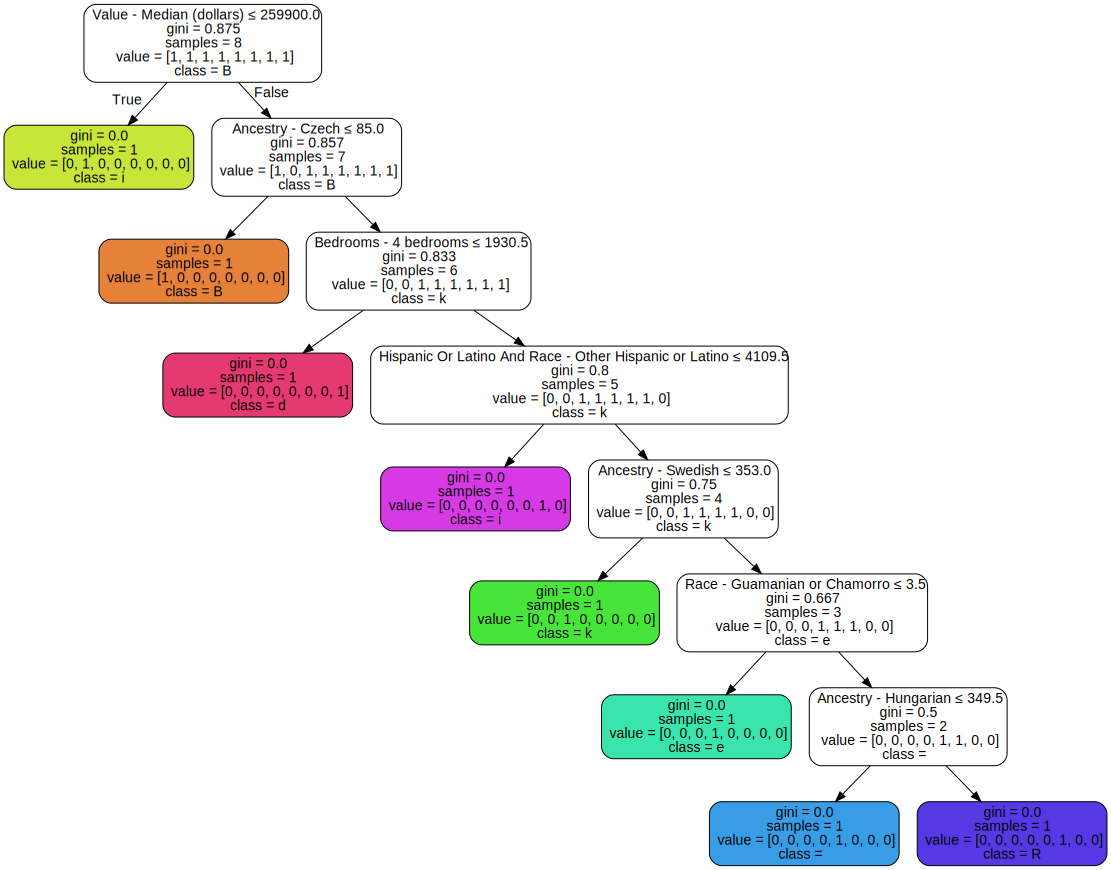

In [18]:
from sklearn import tree
import graphviz 
import pydotplus

clf = tree.DecisionTreeClassifier()
clf = clf.fit(features, target)

dot_data = tree.export_graphviz(
    clf, out_file=None, 
    feature_names=feature_names,  
    class_names=target_name,  
    filled=True, rounded=True,  
    special_characters=True)  

graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('iristree.png')

graph = graphviz.Source(dot_data)  
graph 

In [19]:
rf = RandomForestClassifier(n_estimators=200)
rf = rf.fit(features, target)
rf.score(features, target)

1.0

In [20]:
# import pandas as pd
# important_features = pd.Series(data=clf.feature_importances_,index=feature_names)
# important_features.sort_values(ascending=False,inplace=True)


In [21]:
from sklearn.linear_model import LinearRegression

In [23]:
results_estimated = []

for column in ward_stats_estimate:
    #print(ward_stats_estimate[column])
    X = ward_stats_estimate["Bike Rides by Ward"].values.reshape(-1, 1)
    y = ward_stats_estimate[column].values.reshape(-1, 1)
    model = LinearRegression()
    model.fit(X, y)
    model_coef = model.coef_
    model_intercept = model.intercept_
    model_score = model.score(X, y)
#     print(ward_stats_estimate[column].name)
#     print('Weight coefficients: ', model_coef)
#     print('y-axis intercept: ', model_intercept) 
#     print('Score: ', model_score)     
    results_estimated.append({"Model - Estimated": ward_stats_estimate[column].name, 'Weight coefficients': model_coef, 'y-axis intercept': model_intercept, 'Score': model_score})

results_estimated = pd.DataFrame(results_estimated)



In [24]:
pd.set_option('display.max_colwidth', -1)

In [25]:
results_estimated.sort_values(by=["Score"], ascending=False)

,Model - Estimated,Score,Weight coefficients,y-axis intercept
418,Bike Rides by Ward,1.000000,[[0.9999999999999998]],[5.820766091346741e-11]
286,Residence 1 Year Ago - Same state,1.000000,[[-0.0]],[0.0]
45,Commuting To Work - Walked,0.985378,[[0.011702614599397941]],[1404.1581581483224]
250,Race - Korean,0.928100,[[0.0005673204171004808]],[132.71209385384657]
288,Rooms - 2 rooms,0.841232,[[0.0037737369878398323]],[1823.3697826449832]
287,Rooms - 1 room,0.780008,[[0.0035589961517133273]],[1340.2082192097419]
42,Commuting To Work - Mean travel time to work (minutes),0.771067,[[-6.403880655906708e-06]],[33.156767589604996]
155,Housing Tenure - Average household size of owner-occupied unit,0.766541,[[-5.806552007686194e-07]],[2.644127598051071]
87,"Gross Rent - $3,000 or more",0.763860,[[0.002004327270431038]],[726.6025941628028]
63,Employment Status - All parents in family in labor force,0.733482,[[-0.0029593460080046667]],[6309.226590820014]


In [ ]:
results_percent = []

for column in ward_stats_percent:
    X = ward_stats_percent["Bike Rides by Ward"].values.reshape(-1, 1)
    y = ward_stats_percent[column].values.reshape(-1, 1)
    model = LinearRegression()
    model.fit(X, y)
    model_coef = model.coef_
    model_intercept = model.intercept_
    model_score = model.score(X, y)
     
    results_percent.append({"Model - Percentage": ward_stats_percent[column].name, 'Weight coefficients': model_coef, 'y-axis intercept': model_intercept, 'Score': model_score})

results_percent = pd.DataFrame(results)

In [ ]:
results_percent.sort_values(by=["Score"], ascending=False)
